# Yield PCA Estimation

This notebook explores how Principal Component Analysis (PCA) can be applied to extract macroeconomic factors from historical data and assess how these relationships evolve across different historical windows. The goal is to understand whether the dominant drivers of the yield curve (proxied by the 10Y rate) are stable or regime-dependent, and whether combining information from multiple windows can improve explanatory power.

First, we load the data (see the readme for more info).

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv('data.csv', index_col=0)
df = df.dropna()
df


,10Y,2Y,CPI,FedFunds,VIX,USD_Index,Oil,InflExp,CPI_YoY,Slope,Δ10Y,GDP_Real_SAAR,Federal_Debt_Billions,Debt_To_GDP
2016-02-29,1.74,0.78,237.336,0.38,20.55,114.2418,32.74,1.23,0.847278,0.96,-0.20,18892.206,18922179.0,1001.586527
2016-03-31,1.78,0.73,238.080,0.36,13.95,109.9191,36.94,1.49,0.891616,1.05,0.04,19001.690,19264939.0,1013.853978
2016-04-30,1.83,0.77,238.992,0.37,15.70,108.8274,45.98,1.60,1.172626,1.06,0.05,19001.690,19264939.0,1013.853978
2016-05-31,1.84,0.87,239.557,0.37,14.19,112.4276,49.10,1.47,1.078476,0.97,0.01,19001.690,19264939.0,1013.853978
2016-06-30,1.49,0.58,240.222,0.38,15.63,112.1618,48.27,1.38,1.079287,0.91,-0.35,19062.709,19381591.0,1016.728053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,4.23,3.89,319.615,4.33,22.28,126.9402,71.87,2.61,2.405585,0.34,-0.01,23548.210,36214310.0,1537.879525
2025-04-30,4.17,3.60,320.321,4.33,24.70,122.9440,59.55,2.29,2.333747,0.57,-0.06,23548.210,36214310.0,1537.879525
2025-05-31,4.41,3.89,320.580,4.33,18.57,122.1112,61.46,2.39,2.375934,0.52,0.24,23548.210,36214310.0,1537.879525
2025-06-30,4.24,3.72,321.500,4.33,16.73,119.8269,66.30,2.31,2.672683,0.52,-0.17,23770.976,36211469.0,1523.348011


## Methodology
We group macroeconomic variables into four conceptual blocks representing distinct economic forces:
Block Variables
Inflation:	CPI, CPI_YoY, Inflation Expectations, Oil
Policy:	2Y Treasury, Fed Funds Rate, Yield Curve Slope
Risk:	VIX, USD Index
Fiscal:	Federal Debt, Debt-to-GDP

Each block undergoes Principal Component Analysis (PCA) after standardization.
For every historical window (ranging from 1 to 9 years), the first principal component (PC1) is extracted and interpreted as a latent factor:
- Inflation Factor
- Policy Factor
- Risk Factor
- Fiscal Factor

These factors aim to summarize the structural variance within each group — e.g., the “inflation environment” or “policy stance”.

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define columns
features = ['CPI', 'CPI_YoY', 'InflExp', 'Oil', '2Y', 'FedFunds', 'Slope', 'VIX', 
            'USD_Index', 'Federal_Debt_Billions', 'Debt_To_GDP', 'GDP_Real_SAAR']

inflation_cols = ['CPI', 'CPI_YoY', 'InflExp', 'Oil']
policy_cols = ['2Y', 'FedFunds', 'Slope']
risk_cols = ['VIX', 'USD_Index']
fiscal_cols = ['Federal_Debt_Billions', 'Debt_To_GDP']

df['Growth_Factor'] = StandardScaler().fit_transform(df[['GDP_Real_SAAR']])

# Initialize
winvar = {}
winvecs = {'Infl': {}, 'Pol': {}, 'Risk': {}, 'Fisc': {}}
windows = [12, 24, 36, 60, 96, 114]
scaler = StandardScaler()

dfs = {}
for window in windows:
    win = {}

    # --- Inflation ---
    X_infl = df[inflation_cols].fillna(method='ffill').fillna(method='bfill').tail(window)
    X_infl_scaled = scaler.fit_transform(X_infl)
    pca_infl = PCA()
    pca_infl.fit(X_infl_scaled)
    win['Infl'] = pca_infl.explained_variance_ratio_
    winvecs['Infl'][window] = pca_infl.components_[0]  # Store PC1 loadings

    # --- Policy ---
    X_pol = df[policy_cols].fillna(method='ffill').fillna(method='bfill').tail(window)
    X_pol_scaled = StandardScaler().fit_transform(X_pol)
    pca_pol = PCA()
    pca_pol.fit(X_pol_scaled)
    win['Pol'] = pca_pol.explained_variance_ratio_
    winvecs['Pol'][window] = pca_pol.components_[0]

    # --- Risk ---
    X_risk = df[risk_cols].fillna(method='ffill').fillna(method='bfill').tail(window)
    X_risk_scaled = StandardScaler().fit_transform(X_risk)
    pca_risk = PCA()
    pca_risk.fit(X_risk_scaled)
    win['Risk'] = pca_risk.explained_variance_ratio_
    winvecs['Risk'][window] = pca_risk.components_[0]

    # --- Fiscal ---
    X_fisc = df[fiscal_cols].fillna(method='ffill').fillna(method='bfill').tail(window)
    X_fisc_scaled = StandardScaler().fit_transform(X_fisc)
    pca_fisc = PCA()
    pca_fisc.fit(X_fisc_scaled)
    win['Fisc'] = pca_fisc.explained_variance_ratio_
    winvecs['Fisc'][window] = pca_fisc.components_[0]

    winvar[window] = win
    windf = pd.DataFrame({
        'Inflation_Factor': pca_infl.transform(X_infl_scaled)[:, 0],
        'Policy_Factor': pca_pol.transform(X_pol_scaled)[:, 0],
        'Risk_Factor': pca_risk.transform(X_risk_scaled)[:, 0],
        'Fiscal_Factor': pca_fisc.transform(X_fisc_scaled)[:, 0],
        'Growth_Factor': df['Growth_Factor'],
        '10Y': df['10Y']
    }, index=X_infl.index)
    dfs[window] = windf



/var/folders/gr/_9bw3rfs1_n0_d9qwycddj_r0000gn/T/ipykernel_70331/849580809.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_infl = df[inflation_cols].fillna(method='ffill').fillna(method='bfill').tail(window)
/var/folders/gr/_9bw3rfs1_n0_d9qwycddj_r0000gn/T/ipykernel_70331/849580809.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_pol = df[policy_cols].fillna(method='ffill').fillna(method='bfill').tail(window)
/var/folders/gr/_9bw3rfs1_n0_d9qwycddj_r0000gn/T/ipykernel_70331/849580809.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_risk = df[risk_cols].fillna(method='ffill').fillna(method='bfill').tail(window)
/var/folders/gr/_9bw3rfs1_n0_d9qwycddj_r0000gn/T/ipykernel_70331/849580809.py:53: Future

### Rolling Window Design
Instead of running PCA on the full 8-year dataset, we estimate it over multiple historical windows:
[12, 24, 36, 60, 96, 114] months → corresponding to 1y, 2y, 3y, 5y, 8y, and 9.5y.
This allows us to evaluate:
Variance explained: how dominant each PC is in explaining intra-block dynamics over different periods.
Eigenvector stability: how the relative weights of variables (the loadings) shift over time.
The stability of the PCs across windows indicates whether macroeconomic relationships remain consistent or undergo regime changes.

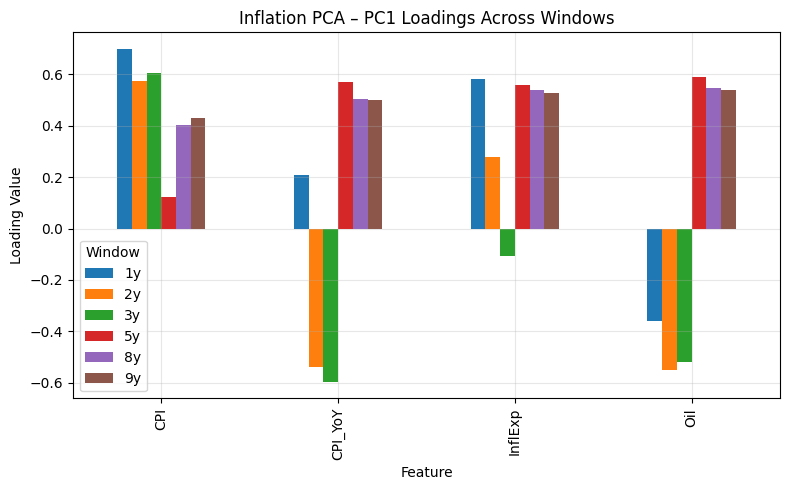

In [ ]:
infl_vecs = pd.DataFrame(winvecs['Infl'], index=inflation_cols)
infl_vecs.columns = [f'{w//12}y' for w in infl_vecs.columns]


infl_vecs.plot(kind='bar', figsize=(8,5))
plt.title('Inflation PCA – PC1 Loadings Across Windows')
plt.ylabel('Loading Value')
plt.xlabel('Feature')
plt.grid(alpha=0.3)
plt.legend(title='Window')
plt.tight_layout()
plt.show()


# Replicate for other PCs at your disgretion by using this code block

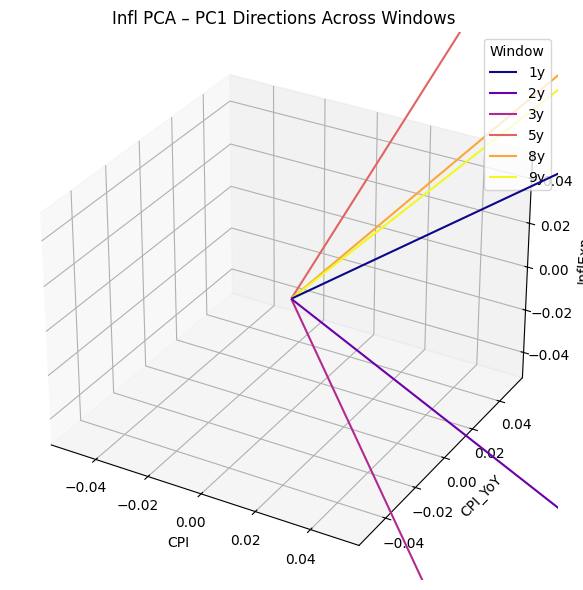

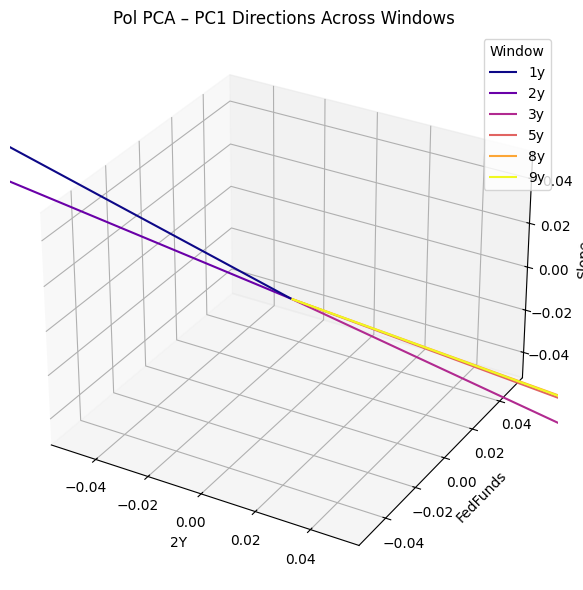

Skipping Risk (only 2 features)
Skipping Fisc (only 2 features)


In [58]:
groups = {
    'Infl': inflation_cols,
    'Pol': policy_cols,
    'Risk': risk_cols,
    'Fisc': fiscal_cols
}


for group, cols in groups.items():
    if len(cols) < 3:
        print(f"Skipping {group} (only {len(cols)} features)")
        continue
    vecs = pd.DataFrame(winvecs[group], index=cols)
    vecs.columns = [f'{w//12}y' for w in vecs.columns]


    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.cm.plasma(np.linspace(0, 1, len(vecs.columns)))
    for i, col in enumerate(vecs.columns):
        v = vecs[col].values
        v = v / np.linalg.norm(v)  # normalize for direction
        ax.quiver(0, 0, 0, v[0], v[1], v[2],
                  color=colors[i], length=1.0, normalize=True, label=col)

    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    ax.set_zlabel(cols[2])
    ax.set_title(f'{group} PCA – PC1 Directions Across Windows')
    ax.legend(title='Window')
    plt.tight_layout()
    plt.show()


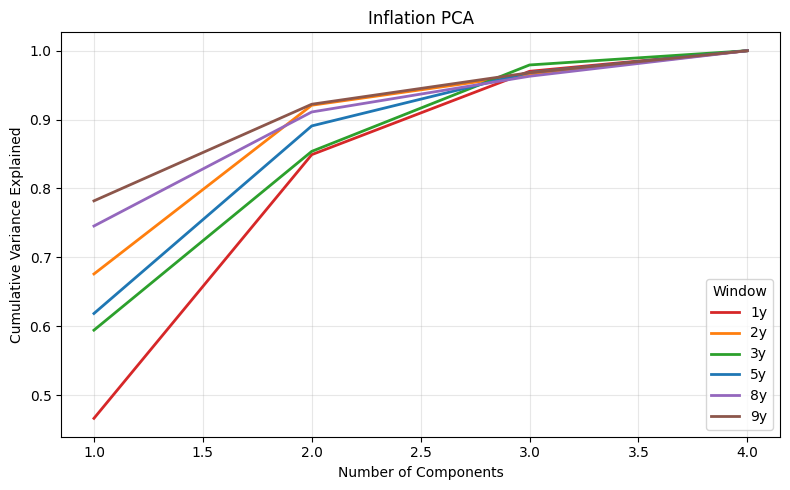

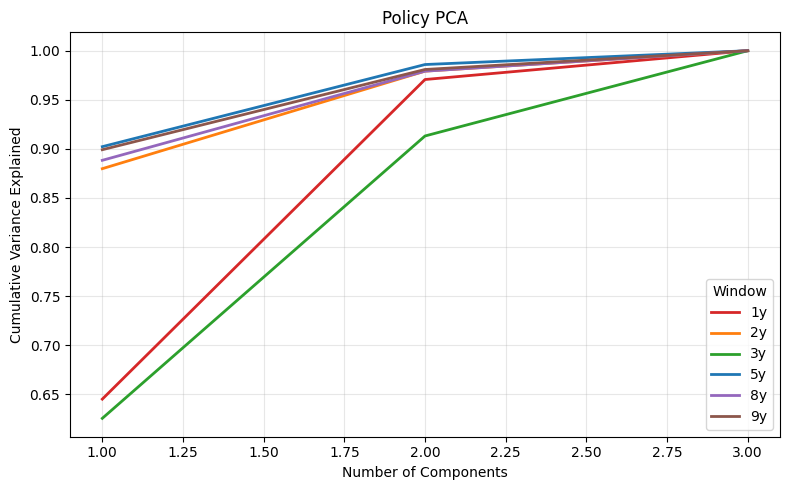

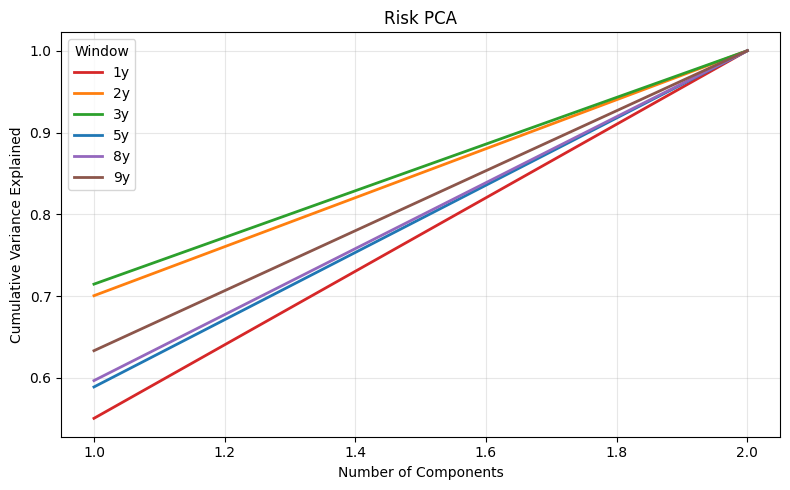

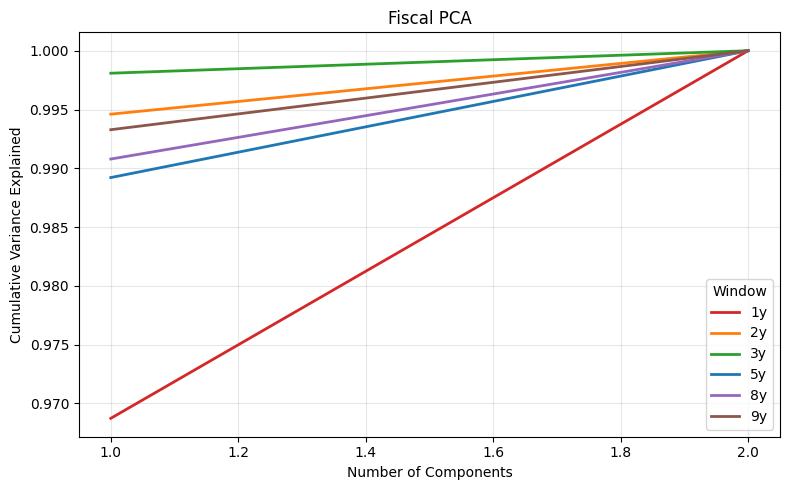

In [50]:
factor_groups = ['Infl', 'Pol', 'Risk', 'Fisc']
factor_titles = {
    'Infl': 'Inflation PCA',
    'Pol': 'Policy PCA',
    'Risk': 'Risk PCA',
    'Fisc': 'Fiscal PCA'
}

window_colors = {
    12: 'tab:red',
    24: 'tab:orange',
    36: 'tab:green',
    60: 'tab:blue',
    96: 'tab:purple',
    114: 'tab:brown'
}

for factor in factor_groups:
    plt.figure(figsize=(8, 5))
    for window in windows:
        cum_var = winvar[window][factor].cumsum()
        plt.plot(
            range(1, len(cum_var) + 1),
            cum_var,
            label=f'{window//12}y',
            color=window_colors.get(window, 'gray'),
            linewidth=2
        )
    plt.title(factor_titles[factor])
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.legend(title='Window')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


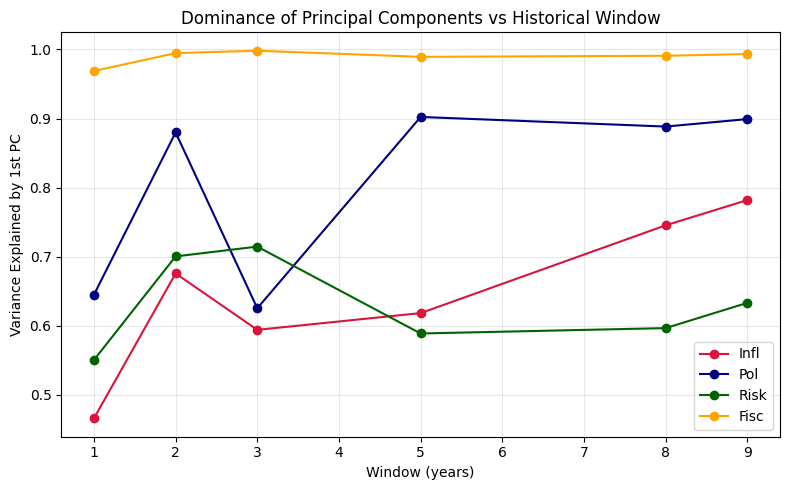

In [51]:
pc1_var = {'Infl': [], 'Pol': [], 'Risk': [], 'Fisc': []}


for window in windows:
    for factor in pc1_var.keys():
        pc1_var[factor].append(winvar[window][factor][0])


plt.figure(figsize=(8,5))
colors = {'Infl': 'crimson', 'Pol': 'navy', 'Risk': 'darkgreen', 'Fisc': 'orange'}

for factor, color in colors.items():
    plt.plot(
        [w//12 for w in windows],
        pc1_var[factor],
        marker='o',
        label=factor,
        color=color
    )

plt.xlabel('Window (years)')
plt.ylabel('Variance Explained by 1st PC')
plt.title('Dominance of Principal Components vs Historical Window')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



## Regression and Results

In [ ]:
results = []

windows = list(dfs.keys())
for r in range(1, len(windows) + 1):
    for combo in itertools.combinations(windows, r):
        dfs_combo = []
        for w in combo:
            temp = dfs[w].copy()
            temp = temp.add_suffix(f"_{w//12}y")
            dfs_combo.append(temp)

        df_merged = pd.concat(dfs_combo, axis=1, join='inner')
        y = df_merged[f'10Y_{combo[-1]//12}y']
        X = df_merged.drop(columns=[col for col in df_merged.columns if '10Y' in col])
        X = sm.add_constant(X)
        if len(y) <= len(X.columns) + 5:
            continue

        model = sm.OLS(y, X).fit()
        results.append({
            'combo': combo,
            'r2': model.rsquared,
            'adj_r2': model.rsquared_adj,
            'n_obs': len(y)
        })

results_df = pd.DataFrame(results).sort_values('r2', ascending=False).reset_index(drop=True)
results_df

,combo,r2,adj_r2,n_obs
0,"(36, 60, 96, 114)",1.000000,1.000000,36
1,"(24, 36, 60)",1.000000,1.000000,24
2,"(60, 96, 114)",1.000000,1.000000,60
3,"(36, 96, 114)",1.000000,1.000000,36
4,"(36, 60, 114)",1.000000,1.000000,36
5,"(36, 60, 96)",1.000000,1.000000,36
6,"(24, 96, 114)",1.000000,1.000000,24
7,"(24, 60, 114)",1.000000,1.000000,24
8,"(24, 60, 96)",1.000000,1.000000,24
9,"(24, 36, 114)",1.000000,1.000000,24
